<a href="https://colab.research.google.com/github/MedCoder001/Breast-Tumor-Segmentation-and-Classification-Using-Ultrasound-Images/blob/main/Breast_Cancer_Segmentation_and__Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd "/content/drive/MyDrive/Kaggle"

/content/drive/MyDrive/Kaggle


In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 95% 185M/195M [00:01<00:00, 106MB/s]
100% 195M/195M [00:01<00:00, 112MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Data

In [ ]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import os

**Load Classes Names**

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Kaggle/Dataset_BUSI_with_GT'
unique_classes = []
for path in os.listdir(BASE_PATH):
  unique_classes.append(path)
print(unique_classes)

['benign', 'malignant', 'normal']


**Assign index to the classes**

In [ ]:
class_index = [unique_classes[2], unique_classes[0], unique_classes[1]]
for c in class_index:
  print(c, "-", class_index.index(c))

normal - 0
benign - 1
malignant - 2


**Load images and masks paths**

In [ ]:
images = []
masks = []
labels = []

for folder in os.listdir(BASE_PATH):
    class_path = os.path.join(BASE_PATH, folder)
    for img in os.listdir(class_path):
        if "_mask" not in img:
            img_path = os.path.join(class_path, img)
            msk_path = img_path.replace(".png", "_mask.png")
            # Check if mask exist
            if os.path.exists(msk_path):
                images.append(img_path)
                masks.append(msk_path)
                labels.append(folder)

In [ ]:
# Printing the number of images and masks
print("Number of images:", len(images))
print("Number of masks:", len(masks))
print("Number of labels:", len(labels))

Number of images: 780
Number of masks: 780
Number of labels: 780


In [ ]:
images[0]

'/content/drive/MyDrive/Kaggle/Dataset_BUSI_with_GT/benign/benign (101).png'

In [ ]:
# Data loading and preprocessing
input_image_size = 256
channel = 1

In [ ]:
import cv2
import scipy
import scipy.ndimage

def load_image(img_path):
  """Load grayscale image"""
  img = cv2.imread(img_path, 0)
  return img


def padding(img, msk):
  """Pad images to make them square"""
  size = np.max(img.shape)

  offset_x = (size - img.shape[0]) // 2
  offset_y = (size - img.shape[1]) // 2

  blank_image = np.zeros((size, size))
  blank_mask = np.zeros((size, size))

  blank_image[offset_x:offset_x+img.shape[0], offset_y:offset_y+img.shape[1]] = img
  blank_mask[offset_x:offset_x+img.shape[0], offset_y:offset_y+img.shape[1]] = msk
  return blank_image, blank_mask


def resize_mask(mask):
  """Resize mask, its different from the image resizing because mask pixel values can change due to resize"""
  new_size = np.array([input_image_size, input_image_size]) / mask.shape
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)
  return mask


def resize_image(img):
  """Resize image"""
  img = cv2.resize(img, (input_image_size, input_image_size))
  return img


def preprocess(img):
  """Preprocess image by normalizing it"""
  img = img / 255.0
  return img


def inverse_preprocess(img):
  """Inverse preprocessing of image"""
  img = img * 255.0
  return img


def load_data(img_path, msk_path, label):
  """Load image and mask and replace mask value with class index
  0 for normal, 1 for benign and 2 for malignant"""
  img = load_image(img_path)
  msk = load_image(msk_path)
  img, msk = padding(img, msk)
  label_index = class_index.index(label)
  msk[msk == 255] = 1
  msk = msk.astype(np.uint8)
  img = resize_image(img)
  msk = resize_mask(msk)
  new_mask = np.zeros((input_image_size, input_image_size, 2))
  if label_index != 0:
      new_mask[:, :, label_index-1] = msk
  # print(np.unique(new_mask), label_index)
  return img, new_mask


def load_batch(images, masks, labels):
  """Load batch of images and masks"""
  batch_x = []
  batch_y = []
  for i, m, l in zip(images, masks, labels):
      img, msk = load_data(i, m, l)
      img = preprocess(img)
      batch_x.append(img)
      batch_y.append(msk)
  return np.array(batch_x), np.array(batch_y)

<ipython-input-20-ea427675fb2d>:29: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 255.0 (256, 256)


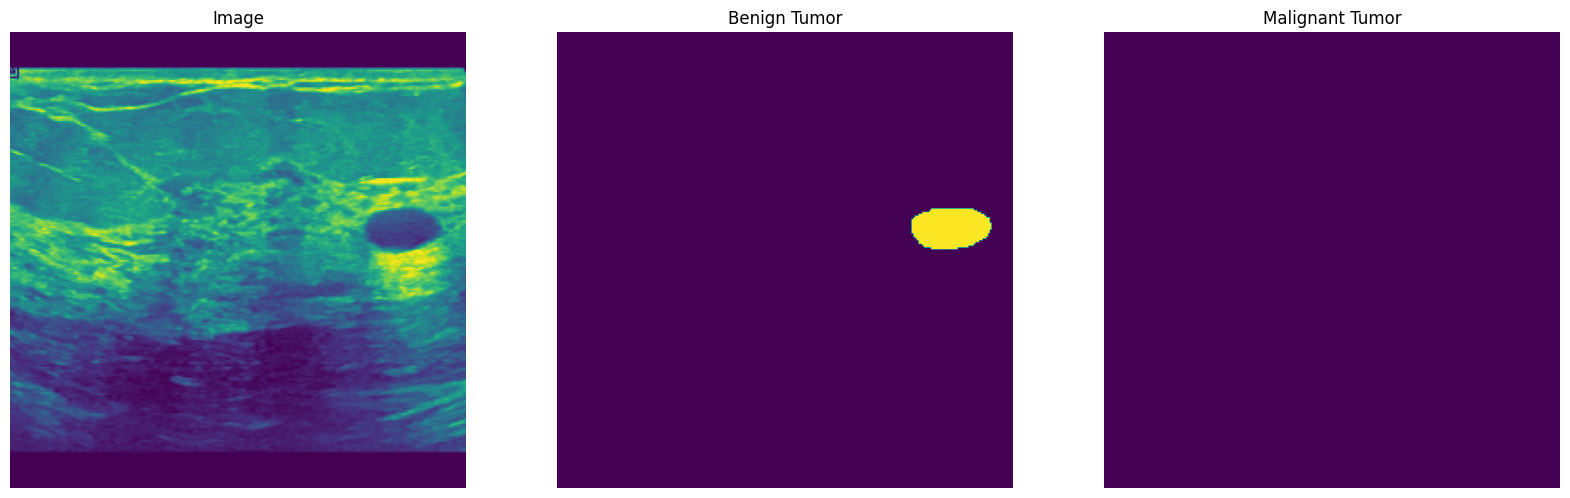

0.0 245.43460083007812 (256, 256)


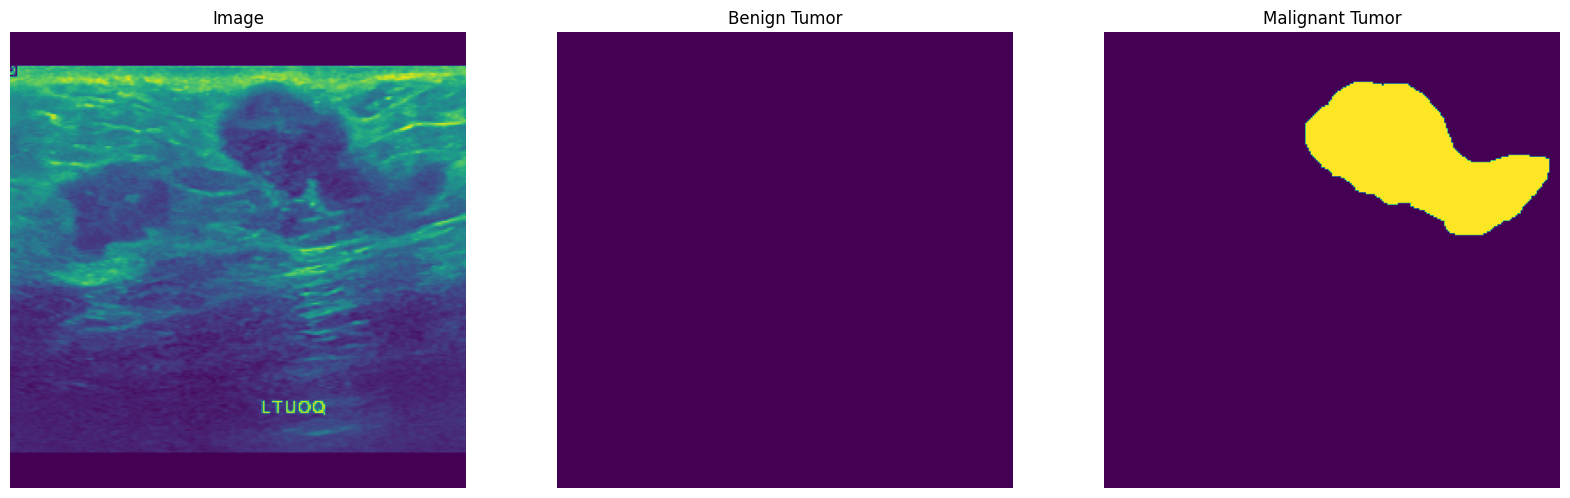

0.0 213.7106056213379 (256, 256)


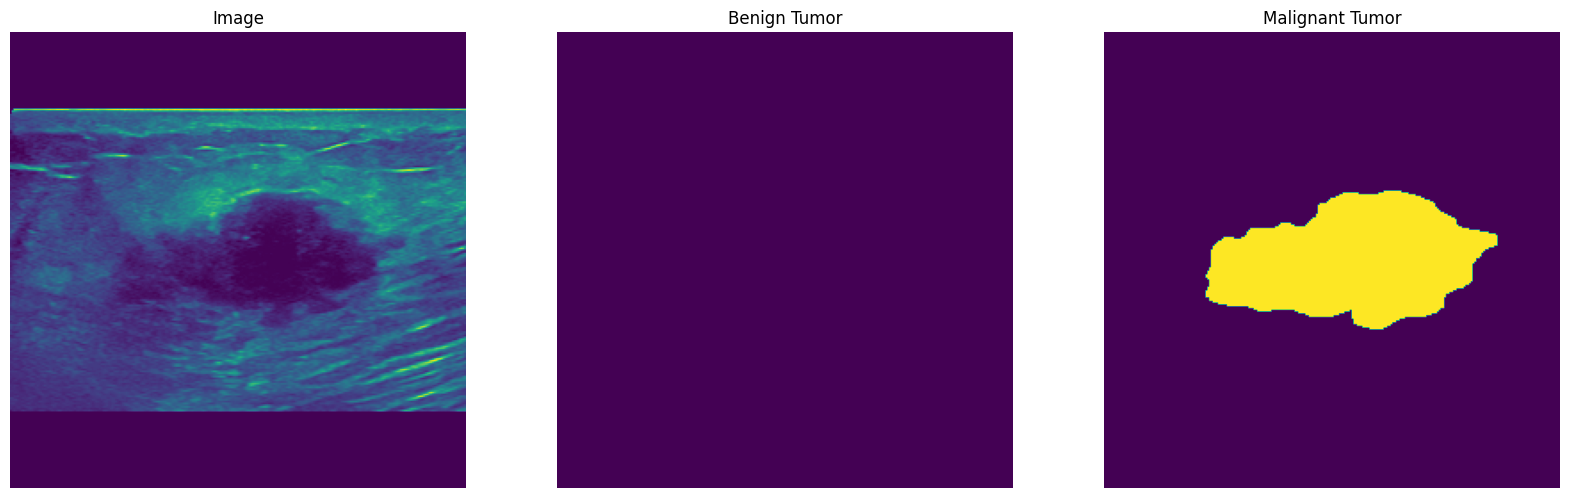

In [ ]:
import matplotlib.pyplot as plt

for i in [0, 500, 600]:
  indx = i
  img, msk = load_data(images[indx], masks[indx], labels[indx])
  print(np.min(img), np.max(img), img.shape)
  plt.figure(figsize=(20, 20))
  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.imshow(img)
  plt.title('Image')
  plt.subplot(1, 3, 2)
  plt.axis('off')
  plt.imshow(msk[:, :, 0])
  plt.title('Benign Tumor')
  plt.subplot(1, 3, 3)
  plt.axis('off')
  plt.imshow(msk[:, :, 1])
  plt.title('Malignant Tumor')
  plt.show()

In [ ]:
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

In [ ]:
labels.shape

(780,)

## **Model** **Building**

In [ ]:
!pip install segmentation_models

In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
from tensorflow import keras

import segmentation_models as sm
# Set the segmentation models framework to 'tf.keras'

sm.set_framework('tf.keras')

# Check the segmentation models framework
sm.framework()

# Model configuration
BACKBONE = 'resnet34'
LR = 0.00001

# Create the UNet model
model = sm.Unet(BACKBONE, classes=2, activation='sigmoid',
                input_shape=(input_image_size, input_image_size, channel),
                encoder_weights=None)

# Compile the model
optim = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# **Training the model**

In [ ]:
print(set(labels))

{'benign', 'normal', 'malignant'}


In [ ]:
len(images)

780

In [ ]:
batch_size = 4
history = {"epoch": []}
for e in range(15):
    print("Epoch: ", e)
    indexes = list(range(len(images)))
    temp_history = {"loss": [],
                    "IOU": [],
                    "F-Score": []}
    for b in range(0, len(images), batch_size):
        bs = b
        be = b + batch_size
        batch_index = indexes[bs:be]
        batch_x, batch_y = load_batch(images[batch_index], masks[batch_index], labels[batch_index])
        batch_x = np.expand_dims(batch_x, axis=-1)
        batch_y = np.expand_dims(batch_y, axis=-1)
        batch_y = batch_y.astype(np.float32)
        loss = model.train_on_batch(batch_x, batch_y)
        temp_history["loss"].append(loss[0])
        temp_history["IOU"].append(loss[1])
        temp_history["F-Score"].append(loss[2])
    print("Loss: ", np.round(np.mean(temp_history["loss"]), 4),
          "IOU: ", np.round(np.mean(temp_history["IOU"]), 4),
          "F-Score: ", np.round(np.mean(temp_history["F-Score"]), 4))
    history["epoch"].append(temp_history)

# Save the model
model.save_weights("breast_tumor_segmenation")


Epoch:  0


<ipython-input-20-ea427675fb2d>:29: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


Loss:  1.0869 IOU:  0.0386 F-Score:  0.0686
Epoch:  1
Loss:  1.0327 IOU:  0.063 F-Score:  0.1035
Epoch:  2


# Testing the model

In [ ]:
index = np.random.choice(list(range(780)), 10)

for i in index:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    print(img.shape)

    img2 = preprocess(img)
    pred = model.predict(np.array[img2])
    pred = pred[0]

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(msk[:, :, 0])
    plt.title('Benign Tumor')
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(msk[:, :, 1])
    plt.title('Malignant Tumor')
    plt.show()
